In [24]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
import pickle
import re

from utilities import data, preds
from utilities.info import *

In [18]:
FILE_DIR = f"{EXPERIMENT_DIR}/files"
FILE_DIR

'W:/experiments/lung-malignancy-fairness-shaurya/files'

## Load Venk21 and PanCan Predictions (NLST)

In [19]:
venk21_pancan = pd.read_csv(f"{FILE_DIR}/NLST_DL_vs_PanCan_Venk21.csv")
venk21_pancan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter [mm]        16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

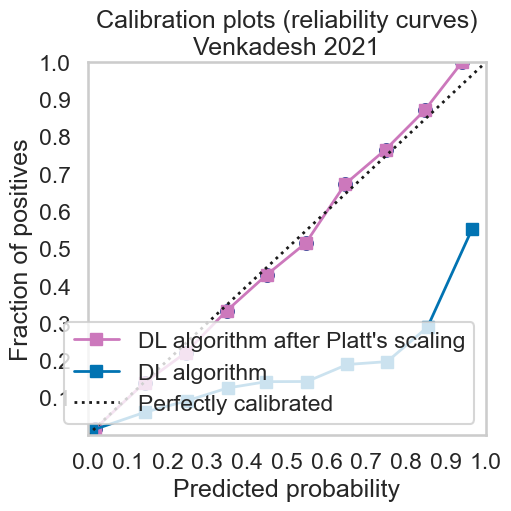

In [20]:
venk21_pancan['DL_cal'] = preds.calibrate_preds(venk21_pancan['DL'], venk21_pancan['label'])
_= preds.make_calibration_plots(venk21_pancan['label'], venk21_pancan['DL'], venk21_pancan['DL_cal'], title='\nVenkadesh 2021')

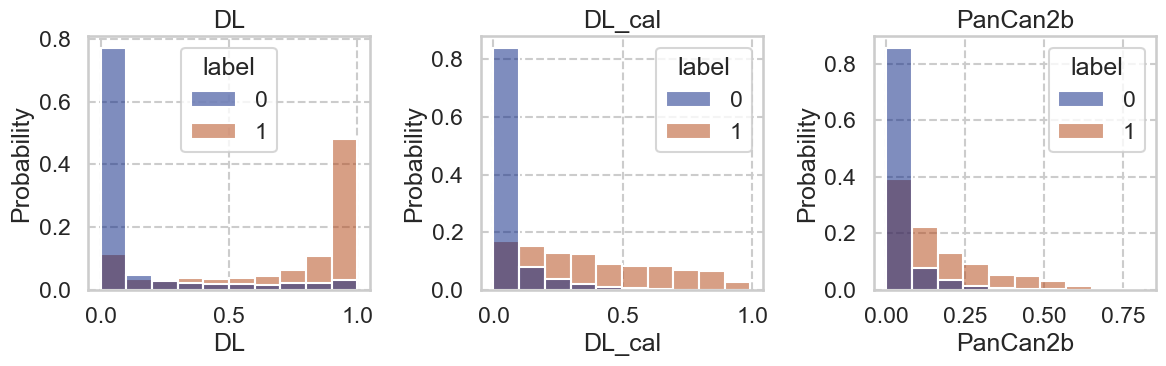

In [21]:
_ = preds.check_scoredists(venk21_pancan, ['DL', 'DL_cal', 'PanCan2b'])

## Load De Haas Models

In [22]:
tijmen_load_info = {
    "Thijmen_mean": {
        "base_path": rf"{FILE_DIR}/NLST_Tijmen_results/final_layer_nlst_validtion_20240626",
        "local": False,
        "valid": False,
    },
    "Thijmen_local": {
        "base_path": rf"{FILE_DIR}/Tijmen Local NLST",
        "local": True,
        "valid": True,
    },
    "Thijmen_global_hidden": {
        "base_path": rf"{FILE_DIR}/Tijmen-Global-Hidden-NLST/clip_hidden_nod_global_nlst_logits_20240422",
        "local": False,
        "valid": True,
    },
    "Thijmen_global_show": {
        "base_path": rf"{FILE_DIR}/Tijmen-Global-ShowNodule-NLST/clip_show_nod_global_nlst_20240501",
        "local": False,
        "valid": True,
    }, 
}

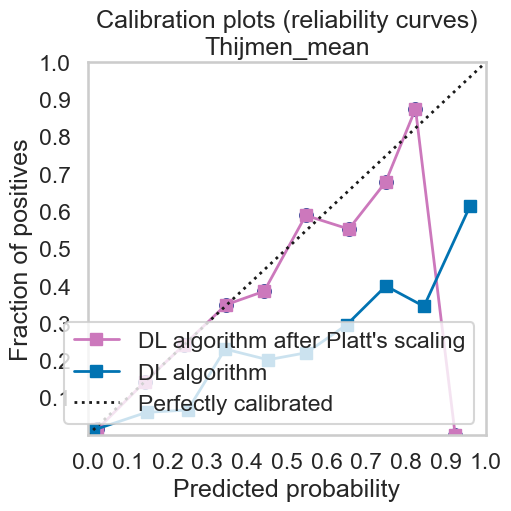

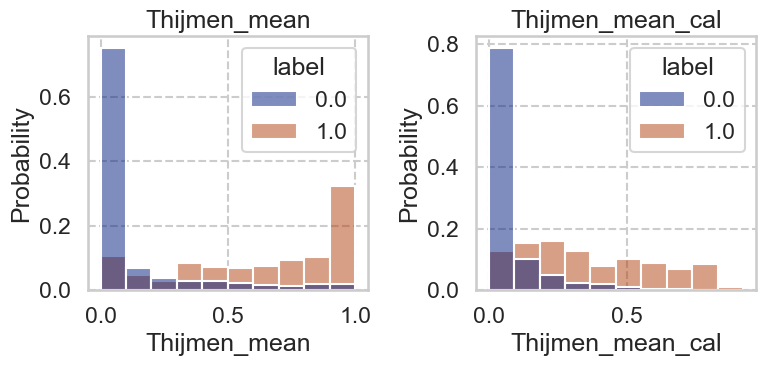

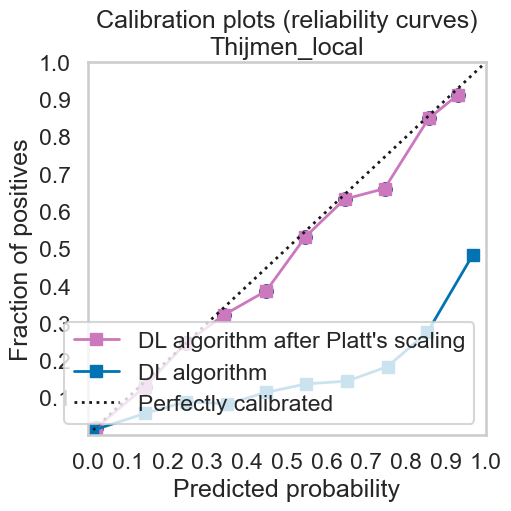

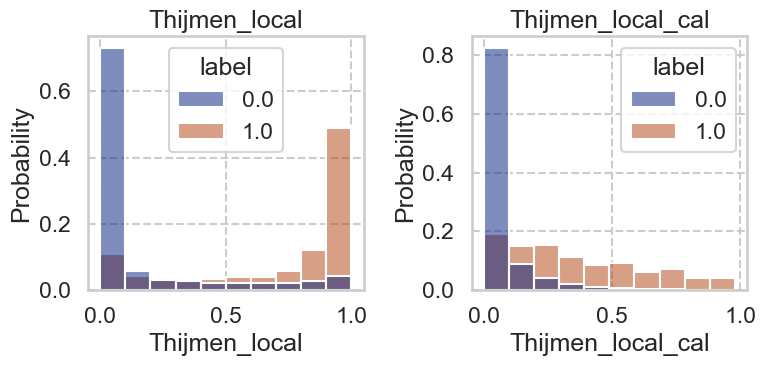

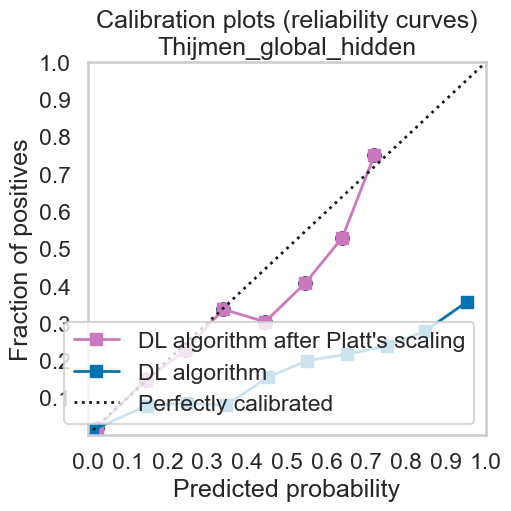

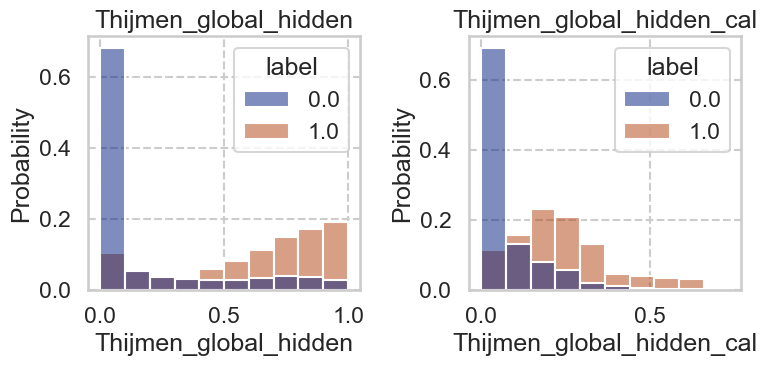

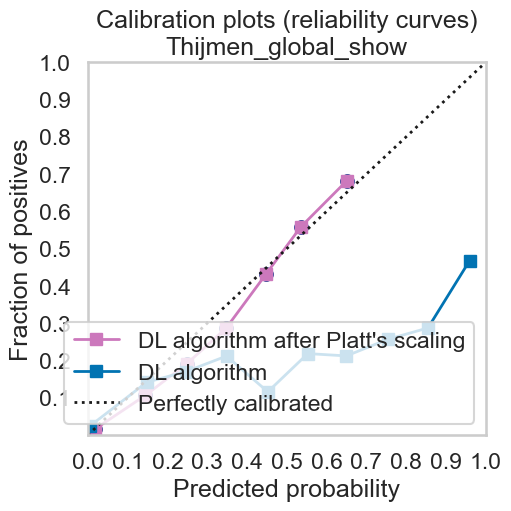

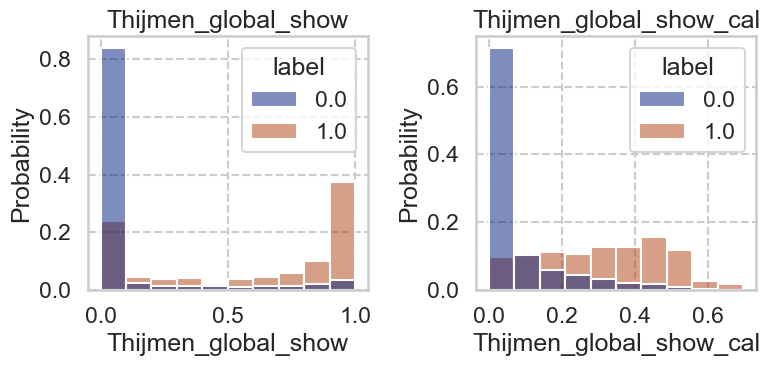

In [23]:
tijmen_dfs = {}
for model in tijmen_load_info:
    df = preds.load_tijmen_results(
        model_name=model,
        base_path=tijmen_load_info[model]['base_path'],
        local=tijmen_load_info[model]['local'],
        valid=tijmen_load_info[model]['valid'],
    )[['AnnotationID', 'label', model]]

    df[f"{model}_cal"] = preds.calibrate_preds(df[model], df['label'])
    preds.make_calibration_plots(
        df['label'], df[model], df[f'{model}_cal'], 
        title=f'\n{model}')
    preds.check_scoredists(df, [model, f'{model}_cal'])

    df.to_csv(f"{tijmen_load_info[model]['base_path']}/combined_{('valid_' if tijmen_load_info[model]['valid'] else '')}output.csv")
    tijmen_dfs[model] = df

## Merge Kiran and Tijmen Predictions

In [27]:
preds = venk21_pancan
for m in tijmen_dfs:
    preds = preds.merge(tijmen_dfs[m], how='left', on=['AnnotationID', 'label'], suffixes=(None, None))

preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter [mm]              16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

## Get Series for Sybil Predictions

This includes the ones from Kiran's (and Tijmen's) cross-validation set which are NOT in Sybil's training set.

In [28]:
LOAD_SYBIL_PICKLE_FILE = True

if LOAD_SYBIL_PICKLE_FILE:
    SYBIL_SERIES_JSON_PATH = f"{FILE_DIR}/sybil-nlst-pid_tp_series2split.p"
    sybil_split_dict = pickle.load(open(SYBIL_SERIES_JSON_PATH, "rb"))

    ids = list(sybil_split_dict.keys())
    splits = list(sybil_split_dict.values())
    pids = [re.split('PID-|__TimePoint-|__Series-', i)[1] for i in ids]
    timepoints = [re.split('PID-|__TimePoint-|__Series-', i)[2] for i in ids]
    siuids = [re.split('PID-|__TimePoint-|__Series-', i)[3] for i in ids]

    sybil_split_df = pd.DataFrame({'id': ids, 'split': splits, 'pid': pids, 'timepoint': timepoints, 'SeriesInstanceUID': siuids})

    sybil_split_df.to_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv", index=False)

else:
    sybil_split_df = pd.read_csv(f"{FILE_DIR}/sybil-nlst-splitinfo.csv")

sybil_split_df

,id,split,pid,timepoint,SeriesInstanceUID
0,PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...,train,204631,0,1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...
1,PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...,train,204631,1,1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...
2,PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...,train,204631,2,1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...
3,PID-126153__TimePoint-2__Series-1.2.840.113654...,train,126153,2,1.2.840.113654.2.55.43665829455927473870872470...
4,PID-126153__TimePoint-1__Series-1.2.840.113654...,train,126153,1,1.2.840.113654.2.55.18862732764668567267836753...
...,...,...,...,...,...
41275,PID-133831__TimePoint-2__Series-1.2.840.113654...,test,133831,2,1.2.840.113654.2.55.26279217761753193890516762...
41276,PID-133831__TimePoint-0__Series-1.2.840.113654...,test,133831,0,1.2.840.113654.2.55.23986337370551290634823184...
41277,PID-116981__TimePoint-0__Series-1.2.840.113654...,test,116981,0,1.2.840.113654.2.55.16179604920107519147811774...
41278,PID-116981__TimePoint-2__Series-1.2.840.113654...,test,116981,2,1.2.840.113654.2.55.59492406653704762882979549...


In [ ]:
sybil_train_ids = set(sybil_split_df.query('split == "train"')['SeriesInstanceUID'])
kiran_series_ids = set(preds['SeriesInstanceUID'])
unique_series_ids = kiran_series_ids - sybil_train_ids

print("Sybil training scans:", len(sybil_train_ids))
print("Venk21 scans (cross-val.):", len(kiran_series_ids))
print("Validation set scans:", len(unique_series_ids))

Sybil training scans: 28160
Venk21 scans (cross-val.): 10183
Validation set scans: 5912


In [29]:
preds['InSybilTrain'] = preds['SeriesInstanceUID'].isin(sybil_train_ids)
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter [mm]              16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

In [32]:
sybil_infer_input = preds.query("SeriesInstanceUID in @unique_series_ids")
sybil_infer_input.to_csv(f"{FILE_DIR}/sybil_val_infer_series.csv", index=False)
sybil_infer_input[['SeriesInstanceUID']].nunique()

SeriesInstanceUID    5912
dtype: int64

After this, convert MHA to DICOM and run Sybil's inference on `DIAGNijmegen/bodyct-sybil-lung-cancer-risk`.

## Merge Sybil Predictions

NOTE: I ran this in two jobs - one for the 1172 scans in the intersection with Tijmen's combined model's validation set, and a second for the 4739 (1 scan failed) on the rest. Ideally, you run it all at once, but I'm gonna merge them here. 

In [39]:
sybil_infer_1172 = pd.read_csv(f"{FILE_DIR}/sybil-inference-1172.csv")
sybil_infer_4739 = pd.read_csv(f"{FILE_DIR}/sybil-inference-4739.csv")
len(sybil_infer_1172), len(sybil_infer_4739)

(1172, 4739)

In [43]:
sybil_infer = pd.concat([sybil_infer_1172, sybil_infer_4739], axis=0, ignore_index=True).drop_duplicates(subset='SeriesInstanceUID')
sybil_infer = sybil_infer.rename(columns={f'year{n+1}': f'sybil_year{n+1}' for n in range(6)})
sybil_infer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SeriesInstanceUID  5911 non-null   object 
 1   sybil_year1        5911 non-null   float64
 2   sybil_year2        5911 non-null   float64
 3   sybil_year3        5911 non-null   float64
 4   sybil_year4        5911 non-null   float64
 5   sybil_year5        5911 non-null   float64
 6   sybil_year6        5911 non-null   float64
dtypes: float64(6), object(1)
memory usage: 323.4+ KB


In [42]:
allpreds = preds.merge(sybil_infer, validate='m:1',
                how="left",
                on=['SeriesInstanceUID'], suffixes=(None,None))
allpreds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  16077 non-null  int64  
 1   StudyDate                  16077 non-null  int64  
 2   SeriesInstanceUID          16077 non-null  object 
 3   CoordX                     16077 non-null  float64
 4   CoordY                     16077 non-null  float64
 5   CoordZ                     16077 non-null  float64
 6   LesionID                   16077 non-null  int64  
 7   NoduleType                 16077 non-null  object 
 8   Spiculation                16077 non-null  bool   
 9   Diameter [mm]              16077 non-null  float64
 10  Age                        16077 non-null  int64  
 11  Gender                     16077 non-null  int64  
 12  FamilyHistoryLungCa        16077 non-null  bool   
 13  Emphysema                  16077 non-null  boo

In [44]:
allpreds.to_csv(f"{FILE_DIR}/nlst_allmodels.csv", index=False)